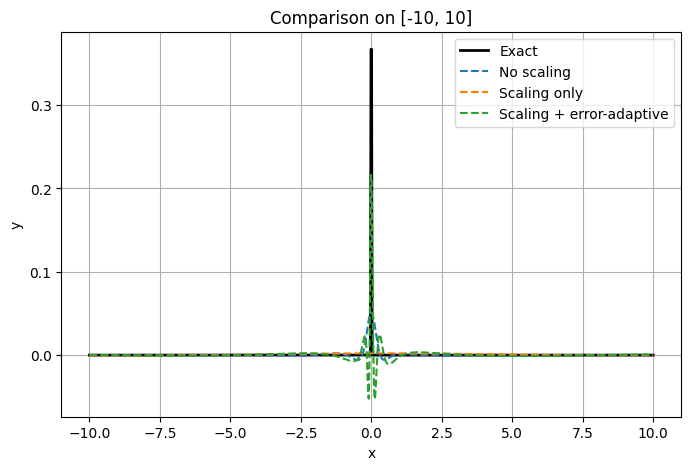

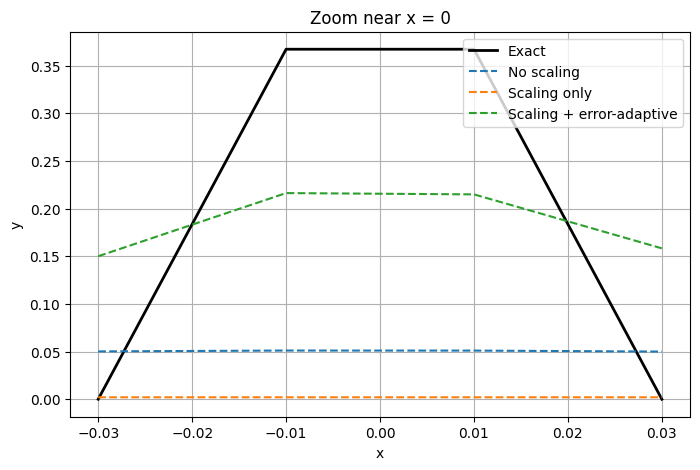

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =========================
# Exact function
# =========================
def exact_function(x):
    return torch.exp(-10000.0 * x**2)

# =========================
# Data: [-10, 10]
# =========================
N = 4000
x = torch.linspace(-10.0, 10.0, N).view(-1, 1).to(device)
y = exact_function(x)

x_scaled = x / 10.0  # scaling to [-1,1]

# =========================
# Neural Network
# =========================
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

# =========================
# Error-adaptive loss
# =========================
def error_adaptive_mse(y_pred, y_true, alpha=0.05, beta=10.0):
    err = torch.abs(y_pred - y_true).detach()
    w = alpha + beta * err / (err.mean() + 1e-8)
    return torch.mean(w * (y_pred - y_true)**2)

# =========================
# Training function
# =========================
def train_model(model, x_in, loss_type="mse", epochs=4000):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    mse = nn.MSELoss()

    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = model(x_in)

        if loss_type == "mse":
            loss = mse(y_pred, y)
        else:
            loss = error_adaptive_mse(y_pred, y)

        loss.backward()
        optimizer.step()

    return model

# =========================
# Case 1: No scaling
# =========================
model1 = MLP().to(device)
model1 = train_model(model1, x, "mse")
y1 = model1(x).detach().cpu()

# =========================
# Case 2: Scaling only
# =========================
model2 = MLP().to(device)
model2 = train_model(model2, x_scaled, "mse")
y2 = model2(x_scaled).detach().cpu()

# =========================
# Case 3: Scaling + adaptive weight
# =========================
model3 = MLP().to(device)
model3 = train_model(model3, x_scaled, "adaptive")
y3 = model3(x_scaled).detach().cpu()

# =========================
# Exact
# =========================
y_exact = y.cpu()
x_cpu = x.cpu()

# =========================
# Plot: Full domain
# =========================
plt.figure(figsize=(8,5))
plt.plot(x_cpu, y_exact, 'k', lw=2, label="Exact")
plt.plot(x_cpu, y1, '--', label="No scaling")
plt.plot(x_cpu, y2, '--', label="Scaling only")
plt.plot(x_cpu, y3, '--', label="Scaling + error-adaptive")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.title("Comparison on [-10, 10]")
plt.show()

# =========================
# Plot: Zoom near peak
# =========================
mask = torch.abs(x_cpu) < 0.05

plt.figure(figsize=(8,5))
plt.plot(x_cpu[mask], y_exact[mask], 'k', lw=2, label="Exact")
plt.plot(x_cpu[mask], y1[mask], '--', label="No scaling")
plt.plot(x_cpu[mask], y2[mask], '--', label="Scaling only")
plt.plot(x_cpu[mask], y3[mask], '--', label="Scaling + error-adaptive")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.title("Zoom near x = 0")
plt.show()
